### Libraries

In [1]:
!git clone https://github.com/openai/universe.git
!cd universe
!pip install -e ./universe

!git clone https://github.com/ZoyaV/ao_env.git
!pip install -e ./ao_env

!git clone --recursive https://github.com/DLR-RM/rl-baselines3-zoo
!cd rl-baselines3-zoo/

!pip install stable-baselines3
!pip install tensorflow==1.13.2

!pip install wandb

Cloning into 'universe'...
remote: Enumerating objects: 1476, done.
remote: Total 1476 (delta 0), reused 0 (delta 0), pack-reused 1476
Receiving objects: 100% (1476/1476), 1.58 MiB | 3.64 MiB/s, done.
Resolving deltas: 100% (938/938), done.
Obtaining file:///content/universe
     |████████████████████████████████| 495 kB 8.1 MB/s 
     |████████████████████████████████| 48 kB 5.4 MB/s 
     |████████████████████████████████| 728 kB 57.3 MB/s 
     |████████████████████████████████| 638 kB 54.6 MB/s 
     |████████████████████████████████| 3.1 MB 55.6 MB/s 
     |████████████████████████████████| 178 kB 58.9 MB/s 
     |████████████████████████████████| 52 kB 1.6 MB/s 
     |████████████████████████████████| 506 kB 69.4 MB/s 
     |████████████████████████████████| 3.0 MB 49.0 MB/s 
     |████████████████████████████████| 74 kB 3.8 MB/s 
     |████████████████████████████████| 251 kB 59.5 MB/s 
  Created wheel for fastzbarlight: filename=fastzbarlight-0.0.14-cp37-cp37m-linux_x86_64.whl 

In [ ]:
#Reload collab enviroment

## Enviroment 

In [1]:
import gym
import universe


In [ ]:
env = gym.make('ao_env:ao-v0')

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Starting Sim: 2021-08-31-13-50-12
Pixel Scale: 12.50 pxls/m
subScreenSize: 140 simulation pixels
Creating mask...
Turbulence summary @ 500 nm:
| r0 = 0.16 m (0.64" seeing)
| Vbar_5/3 = 11.78 m/s
| tau0 = 4.26 ms
Initialise Infinite Phase Screen 1
Initialise Infinite Phase Screen 2
Initialise Infinite Phase Screen 3
Initialise Infinite Phase Screen 4
Initialising WFSs....
WFS 0: 104 measurements
Initialising 2 DMs...
Making DM Influence Functions...
DM 0: 2 active actuators
Making DM Influence Functions...
DM 1: 30 active actuators
32 total DM Actuators
Initialising Reconstructor...
Initialising 2 Science Cams...
Generating fftw3 plan....
If this takes too long, change fftw_FLAGS.
Done!
Generating fftw3 plan....
If this takes too long, change fftw_FLAGS.
Done!
Initialise Data Storage...
Initialisation Complete!
Making interaction Matrices...
Creating Interaction Matrix for DM 0 
2 of 2: Generating 2 Actuator DM iMat
Checking for redundant actuators...
DM 0 has 2 valid actuators (0 dropp

#### Enviroment states

Состояние среды - это изображение светового объекта приходящего с научной камеры. 

4 of 100000: sh_8x8  Strehl -- sci_0: inst 0.42, long 0.23 sci_1: inst 0.07, long 0.07 

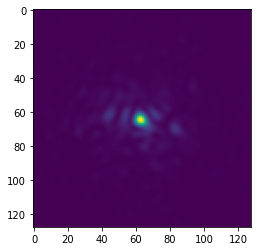

In [ ]:
state, r, done, _ = env.step(env.expert())
env.render()

Область значаний состояний среды

In [ ]:
env.observation_space

Box(0, 255, (128, 128, 3), uint8)

#### Деформируемое зеркало и сигналы для манипулирования

Через несколько итераций изображение становится более четким за счет использования датчика волнового фронта, который высчитывает управляющие сигналы для деформируемого зеркала.
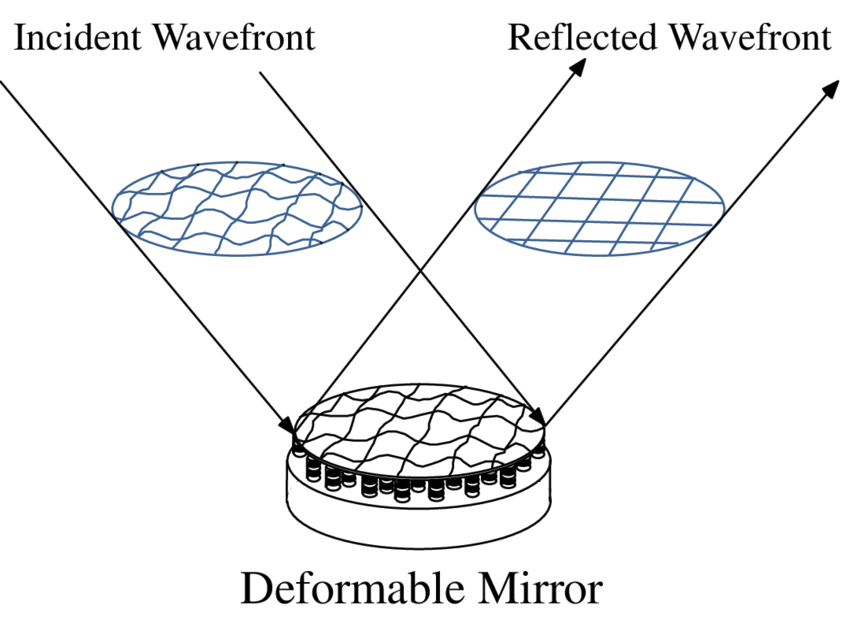

Работу датчика волнового фронта в среде выполняет команда env.expert()

In [ ]:
env.expert()

array([-0.03869431,  0.13228272,  0.0177697 , -0.05793378,  0.31043229,
        0.00489347,  0.41960052,  0.39066461,  0.25429335,  0.37159034,
        0.20715543, -0.04748062,  0.03403265, -0.09831914,  0.10469657,
        0.18142442, -0.08995731, -0.1032226 , -0.22736808,  0.05687972,
       -0.20021047, -0.11854155,  0.05726384, -0.06176505,  0.05777593,
       -0.04467752,  0.05564933,  0.050655  , -0.17496582,  0.00465304,
       -0.07997392, -0.10185839])

#### Задача - предсказание управляющих сигналов для деформируемого зеркала

Область значение действий в среде

In [ ]:
env.action_space

Box(-50.0, 50.0, (32,), float32)

#### Оценка среды  1/sqrt(exp(rmse(action - expert)))

## Plots settings

In [ ]:
import wandb
from stable_baselines3.common.logger import Logger
from stable_baselines3.common.monitor import Monitor
import gym

In [ ]:

class WbLogger(Logger):
    def __init__(self, wb):
        super().__init__(None, [])
        self.wb = wb
        self.steps = 0

    def dump(self, step=0) -> None:
        pass

    def record(self, key, value, exclude=None) -> None:
        if key == 'time/total_timesteps':
            self.steps = value
        else:
            self.wb.log({key: value, 'train/steps': self.steps})


class WbMonitor(Monitor):
    def __init__(self, env: gym.Env, wb):
        super().__init__(env)
        self.wb = wb

    def step(self, action):
        observation, reward, done, info = super().step(action)
        # if done:
        #     if self.episode_returns and self.episode_times and self.episode_lengths:
        self.wb.log({"train/steps": self.total_steps,
                      "train/reward": reward,
                      # "train/episode_lengths": self.episode_lengths[-1],
                      # "train/episode_times": self.episode_times[-1],
                      })

        return observation, reward, done, info

## RL experiments

### PPO

In [ ]:
import gym
import universe

In [ ]:
from stable_baselines3.ppo import CnnPolicy
from stable_baselines3 import PPO

In [ ]:
wb = wandb.init(project='PP0-exp1-RewardWbMonitor')
env = gym.make('ao_env:ao-v0')
env = WbMonitor(env, wb=wb)


<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Starting Sim: 2021-09-01-10-59-50
Pixel Scale: 12.50 pxls/m
subScreenSize: 140 simulation pixels
Creating mask...
Turbulence summary @ 500 nm:
| r0 = 0.16 m (0.64" seeing)
| Vbar_5/3 = 11.78 m/s
| tau0 = 4.26 ms
Initialise Infinite Phase Screen 1
Initialise Infinite Phase Screen 2
Initialise Infinite Phase Screen 3
Initialise Infinite Phase Screen 4
Initialising WFSs....
WFS 0: 104 measurements
Initialising 2 DMs...
Making DM Influence Functions...
DM 0: 2 active actuators
Making DM Influence Functions...
DM 1: 30 active actuators
32 total DM Actuators
Initialising Reconstructor...
Initialising 2 Science Cams...
Generating fftw3 plan....
If this takes too long, change fftw_FLAGS.
Done!
Generating fftw3 plan....
If this takes too long, change fftw_FLAGS.
Done!
Initialise Data Storage...
Initialisation Complete!
Making interaction Matrices...
Creating Interaction Matrix for DM 0 
2 of 2: Generating 2 Actuator DM iMat
Checking for redundant actuators...
DM 0 has 2 valid actuators (0 dropp

In [ ]:
%%wandb

model = PPO(CnnPolicy, env, verbose=1, n_steps= 25)
model.set_logger(WbLogger(wb))

for i in range(1):
  model.learn(total_timesteps=100000)

wandb.final()

Using cpu device
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


/usr/local/lib/python3.7/dist-packages/stable_baselines3/ppo/ppo.py:138: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 25`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 25
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=25 and n_envs=1)
  f"You have specified a mini-batch size of {batch_size},"


Loading configuration file...
Pixel Scale: 12.50 pxls/m
subScreenSize: 140 simulation pixels
Loading configuration file... success!
Starting Sim: 2021-09-01-11-00-56
Pixel Scale: 12.50 pxls/m
subScreenSize: 140 simulation pixels
Creating mask...
Turbulence summary @ 500 nm:
| r0 = 0.16 m (0.64" seeing)
| Vbar_5/3 = 11.78 m/s
| tau0 = 4.26 ms
Initialise Infinite Phase Screen 1
Initialise Infinite Phase Screen 2
Initialise Infinite Phase Screen 3
Initialise Infinite Phase Screen 4
Initialising WFSs....
WFS 0: 104 measurements
Initialising 2 DMs...
Making DM Influence Functions...
DM 0: 2 active actuators
Making DM Influence Functions...
DM 1: 30 active actuators
32 total DM Actuators
Initialising Reconstructor...
Initialising 2 Science Cams...
Generating fftw3 plan....
If this takes too long, change fftw_FLAGS.
Done!
Generating fftw3 plan....
If this takes too long, change fftw_FLAGS.
Done!
Initialise Data Storage...
Initialisation Complete!
Making interaction Matrices...
Creating Intera

In [ ]:
model.set_logger(WbLogger(wb))

for i in range(1):
  model.learn(total_timesteps=100000)

wandb.final()

Loading configuration file...
Pixel Scale: 12.50 pxls/m
subScreenSize: 140 simulation pixels
Loading configuration file... success!
Starting Sim: 2021-09-01-15-19-18
Pixel Scale: 12.50 pxls/m
subScreenSize: 140 simulation pixels
Creating mask...
Turbulence summary @ 500 nm:
| r0 = 0.16 m (0.64" seeing)
| Vbar_5/3 = 11.78 m/s
| tau0 = 4.26 ms
Initialise Infinite Phase Screen 1
Initialise Infinite Phase Screen 2
Initialise Infinite Phase Screen 3
Initialise Infinite Phase Screen 4
Initialising WFSs....
WFS 0: 104 measurements
Initialising 2 DMs...
Making DM Influence Functions...
DM 0: 2 active actuators
Making DM Influence Functions...
DM 1: 30 active actuators
32 total DM Actuators
Initialising Reconstructor...
Initialising 2 Science Cams...
Generating fftw3 plan....
If this takes too long, change fftw_FLAGS.
Done!
Generating fftw3 plan....
If this takes too long, change fftw_FLAGS.
Done!
Initialise Data Storage...
Initialisation Complete!
Making interaction Matrices...
Creating Intera

### SAC

In [ ]:
from stable_baselines3.sac import CnnPolicy
from stable_baselines3 import SAC

In [ ]:
wb = wandb.init(project='SAC-exp1-RewardWbMonitor')
env = gym.make('ao_env:ao-v0')
env = WbMonitor(env, wb=wb)


train/steps,1141
train/reward,0.0
_runtime,131
_timestamp,1626550056
_step,1140


train/steps,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/reward,█▁▂▁▂▁▁▁▁▁▅▂▁▁▁▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


Loading configuration file...
Pixel Scale: 12.50 pxls/m
subScreenSize: 140 simulation pixels
Loading configuration file... success!
Starting Sim: 2021-07-17-19-27-51
Pixel Scale: 12.50 pxls/m
subScreenSize: 140 simulation pixels
Creating mask...
Turbulence summary @ 500 nm:
| r0 = 0.16 m (0.64" seeing)
| Vbar_5/3 = 11.78 m/s
| tau0 = 4.26 ms
Initialise Infinite Phase Screen 1
Initialise Infinite Phase Screen 2
Initialise Infinite Phase Screen 3
Initialise Infinite Phase Screen 4
Initialising WFSs....
WFS 0: 104 measurements
Initialising 2 DMs...
Making DM Influence Functions...
DM 0: 2 active actuators
Making DM Influence Functions...
DM 1: 30 active actuators
32 total DM Actuators
Initialising Reconstructor...
Initialising 2 Science Cams...
Generating fftw3 plan....
If this takes too long, change fftw_FLAGS.
Done!
Generating fftw3 plan....
If this takes too long, change fftw_FLAGS.
Done!
Initialise Data Storage...
Initialisation Complete!
Making interaction Matrices...
Creating Intera

In [ ]:
%%wandb

model = SAC(CnnPolicy, env, verbose=1,  buffer_size = 1000, train_freq = 1000)
model.set_logger(WbLogger(wb))

for i in range(1):
  model.learn(total_timesteps=14000)

wandb.final()

Using cpu device
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Loading configuration file...
Pixel Scale: 12.50 pxls/m
subScreenSize: 140 simulation pixels
Loading configuration file... success!
Starting Sim: 2021-07-17-19-27-54
Pixel Scale: 12.50 pxls/m
subScreenSize: 140 simulation pixels
Creating mask...
Turbulence summary @ 500 nm:
| r0 = 0.16 m (0.64" seeing)
| Vbar_5/3 = 11.78 m/s
| tau0 = 4.26 ms
Initialise Infinite Phase Screen 1
Initialise Infinite Phase Screen 2
Initialise Infinite Phase Screen 3
Initialise Infinite Phase Screen 4
Initialising WFSs....
WFS 0: 104 measurements
Initialising 2 DMs...
Making DM Influence Functions...
DM 0: 2 active actuators
Making DM Influence Functions...
DM 1: 30 active actuators
32 total DM Actuators
Initialising Reconstructor...
Initialising 2 Science Cams...
Generating fftw3 plan....
If this takes too long, change fftw_FLAGS.
Done!
Generating fftw3 plan....
If this takes too long, change fftw_FLAGS.
Done!
Initi

KeyboardInterrupt: ignored

### DDPG

In [ ]:
from stable_baselines3.ddpg import CnnPolicy
from stable_baselines3 import DDPG
import wandb

In [ ]:
wb = wandb.init(project='DDPG-exp1-RewardWbMonitor')
env = gym.make('ao_env:ao-v0')
env = WbMonitor(env, wb=wb)


train/steps,0
train/reward,0.55186
_runtime,1048
_timestamp,1626552494
_step,10000
train/learning_rate,0.001


train/steps,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/reward,▇▆▄▂▆▂▂▄▇▅▄▄▅▆▅▇▆▄▄▅▂▅▅▇▆▄▇▃▁▄▆▄▆▆▆▃▅▇█▇
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,▁


Loading configuration file...
Pixel Scale: 12.50 pxls/m
subScreenSize: 140 simulation pixels
Loading configuration file... success!
Starting Sim: 2021-07-17-20-12-40
Pixel Scale: 12.50 pxls/m
subScreenSize: 140 simulation pixels
Creating mask...
Turbulence summary @ 500 nm:
| r0 = 0.16 m (0.64" seeing)
| Vbar_5/3 = 11.78 m/s
| tau0 = 4.26 ms
Initialise Infinite Phase Screen 1
Initialise Infinite Phase Screen 2
Initialise Infinite Phase Screen 3
Initialise Infinite Phase Screen 4
Initialising WFSs....
WFS 0: 104 measurements
Initialising 2 DMs...
Making DM Influence Functions...
DM 0: 2 active actuators
Making DM Influence Functions...
DM 1: 30 active actuators
32 total DM Actuators
Initialising Reconstructor...
Initialising 2 Science Cams...
Generating fftw3 plan....
If this takes too long, change fftw_FLAGS.
Done!
Generating fftw3 plan....
If this takes too long, change fftw_FLAGS.
Done!
Initialise Data Storage...
Initialisation Complete!
Making interaction Matrices...
Creating Intera

In [ ]:
%%wandb

model = DDPG(CnnPolicy, env, buffer_size = 1000, train_freq = 10000)
model.set_logger(WbLogger(wb))

for i in range(1):
  model.learn(total_timesteps=10000)

wandb.final()

Loading configuration file...
Pixel Scale: 12.50 pxls/m
subScreenSize: 140 simulation pixels
Loading configuration file... success!
Starting Sim: 2021-07-17-20-12-43
Pixel Scale: 12.50 pxls/m
subScreenSize: 140 simulation pixels
Creating mask...
Turbulence summary @ 500 nm:
| r0 = 0.16 m (0.64" seeing)
| Vbar_5/3 = 11.78 m/s
| tau0 = 4.26 ms
Initialise Infinite Phase Screen 1
Initialise Infinite Phase Screen 2
Initialise Infinite Phase Screen 3
Initialise Infinite Phase Screen 4
Initialising WFSs....
WFS 0: 104 measurements
Initialising 2 DMs...
Making DM Influence Functions...
DM 0: 2 active actuators
Making DM Influence Functions...
DM 1: 30 active actuators
32 total DM Actuators
Initialising Reconstructor...
Initialising 2 Science Cams...
Generating fftw3 plan....
If this takes too long, change fftw_FLAGS.
Done!
Generating fftw3 plan....
If this takes too long, change fftw_FLAGS.
Done!
Initialise Data Storage...
Initialisation Complete!
Making interaction Matrices...
Creating Intera

KeyboardInterrupt: ignored

### Test models

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
base = '/content/gdrive/My Drive/'

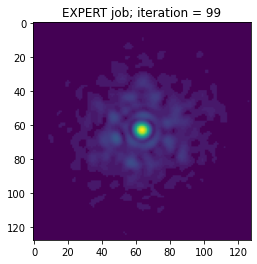

104 of 100000: sh_8x8  Strehl -- sci_0: inst 0.02, long 0.34 sci_1: inst 0.03, long 0.11 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


ValueError: ignored

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fb489f7f8d0>> (for post_run_cell):


Exception: ignored

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import imageio
import os

env = gym.make('ao_env:ao-v0')
state = env.reset()
filenames = []
for i in range(100):
  #action = model.predict(state)
  state, reward, _, _ = env.step(env.expert())
  plt.title("EXPERT job; iteration = %d"%i)
  plt.imshow(state[:,:,0]**0.5)
  

  filename = base+'%d.png'%i

  plt.savefig(filename)
  filenames.append(filename)
  plt.show()
  clear_output(True)


for i in range(100,200):
  action = model.predict(state)
  state = env.imitation(action[0])
  plt.imshow(state[:,:,0]**0.5)
  plt.title("AGENT job; iteration = %d"%i)
  
  filename = base+'%d.png'%i

  plt.savefig(filename)
  filenames.append(filename)
  plt.show()
  clear_output(True)

# build gif
with imageio.get_writer(base+'mygif.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)

In [ ]:
wandb.final()

AttributeError: ignored